In [1]:
%load_ext autoreload
%autoreload 2

%cd ../..
!hostname

/mnt/localdata/datasets/vervet1818-3d
medpc177


In [10]:
pyramid = 6

ev_path = f"data/aa/volume/brain_visa/equivolumic_depth_{pyramid}.nii.gz"
cortex_path = f"data/aa/volume/brain_visa/cortex_{pyramid}.nii"


###

import pli
import numpy as np

from pli.data.functions import write_nifti

lp_section = pli.data.Section(ev_path)
cortex_section = pli.data.Section(cortex_path)

spacing = tuple(s / 1_000 for s in lp_section.spacing)
origin = (0., 0., 0.)
volume = lp_section.image
volume_wm = cortex_section.image == 200
volume_bg = cortex_section.image == 0

Warning! Printing mask for non integer like array


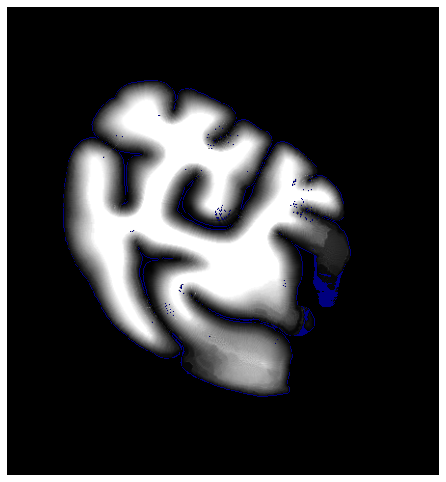

In [11]:
ix = 120

###

import pli.image as im

corrupt_px = (volume == 0) & (~volume_bg)

im.show(volume[:, ix, :], mask=corrupt_px[:, ix, :], alpha=1.0, size=6)

In [12]:
n_samples = 25_000_000

from scipy.interpolate import NearestNDInterpolator

valid_px = np.argwhere(~corrupt_px)

select_ix = np.random.choice(np.arange(len(valid_px)), n_samples)

coords = valid_px[select_ix]

values = volume[coords[:, 0], coords[:, 1], coords[:, 2]]

interp = NearestNDInterpolator(coords, values)

fills = interp(np.argwhere(corrupt_px))
volume[corrupt_px] = fills

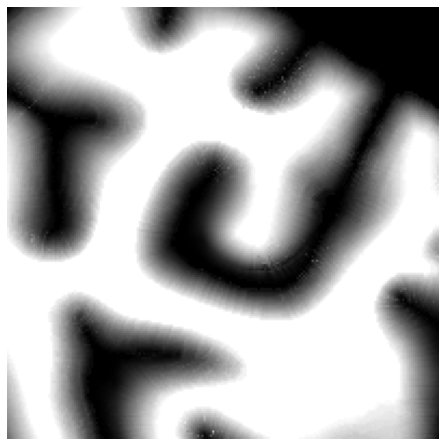

In [13]:
ix = 120

###

import pli.image as im

im.show(volume[100:300, ix, 100:300], size=6)

In [14]:
median_kernel = (5, 5, 5)

###

from scipy import ndimage as ndi

# Smooth volume in z direction
median_volume = ndi.median_filter(volume, size=median_kernel)

# Get original wm bg classes
median_volume[volume_bg] = 0.
median_volume[volume_wm] = 1.

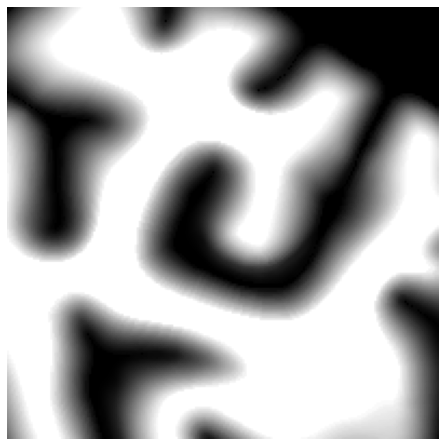

In [15]:
ix = 120

###

import pli.image as im

im.show(median_volume[100:300, ix, 100:300], size=6)

In [16]:
# Write files

lp_out = f"data/aa/volume/brain_visa/equivolumic_depth_{pyramid}_fixed.nii"
gzip = True

###

lp_section.close_file_handle()

affine = np.diag((*spacing, 1))
affine[:3, 3] = origin

write_nifti(lp_out, median_volume.transpose(2, 1, 0)[::-1, : ,:], affine, gzip=gzip)